In [120]:
import torch #for building nn and manipulate tensors
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random #for shuffling values 
import torchmetrics #calculate evaluation metrics 
import pandas as pd
%matplotlib inline

In [121]:
#Read words in our VENEZUELAN dataset
names= open('corpus/name_list_vzl.txt', 'r', encoding='utf-8').read().lower().splitlines()
print(f'Number of names in dataset:{len(set(names))}')

Number of names in dataset:523


In [122]:
#Building vocabulary 
chars = sorted(list(set(''.join(names)))) 
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 #adds dot in position 0 for building block size 
itos = {i:s for s,i in stoi.items()} 
len_vocab= len(itos)
print(itos)
print(f'Lenght of vocabulary: {len_vocab}') 

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'á', 29: 'é', 30: 'í', 31: 'ó', 32: 'ú', 0: '.'}
Lenght of vocabulary: 33


In [123]:
# Build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], [] #X are the values, Y are the labels 
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(names) #shuffles names in dataset 


#Train/validation/test 
n1 = int(0.8*len(names)) 
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1]) #training split. 80%.
Xdev, Ydev = build_dataset(names[n1:n2]) #validation split. 10%. 
Xte, Yte = build_dataset(names[n2:]) #test split. 10%. 

torch.Size([3612, 3]) torch.Size([3612])
torch.Size([437, 3]) torch.Size([437])
torch.Size([490, 3]) torch.Size([490])


In [124]:
#Shape of training split (X and Y)
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([3612, 3]), torch.int64, torch.Size([3612]), torch.int64)

In [125]:
#Setting number of neurons
neurons= 400

In [126]:
#Building of NN 
g = torch.Generator().manual_seed(2147483647) # for reproducibility
dim_embedding = 10 #dimensions of embedding 

C = torch.randn((len_vocab, dim_embedding), generator=g) #Look-up table C 
W1 = torch.randn((dim_embedding*block_size, neurons), generator=g) #hidden layer. Random initialized weights. 6 because 3x2. 100 variable.
b1 = torch.randn(neurons, generator=g) #bias 
W2 = torch.randn((neurons, len_vocab), generator=g) #softmax function (outputs)
b2 = torch.randn(len_vocab, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True #states that gradients have to be computed for each parameter 

In [127]:
# Number of parameters in total
sum(p.nelement() for p in parameters) 

25963

In [128]:
#Keeping track of learning rate and loss 

lri= []
lossi=[]
stepi=[]
loss_val= []

for i in range(60000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (60,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*dim_embedding) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

  emb_val = C[Xdev]
  h = torch.tanh(emb_val.view(-1, block_size*dim_embedding) @ W1 + b1) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Ydev)
  loss_val.append(loss.log10().item())

#print(loss.item())

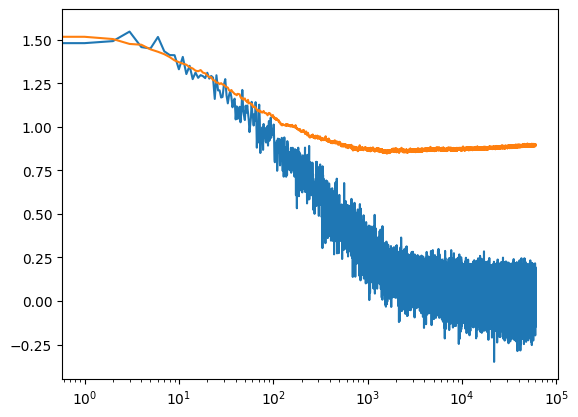

In [129]:
#Plotting loss of traning and validation curves 
plt.semilogx(stepi, lossi)
plt.semilogx(stepi, loss_val)
plt.show()

iters_opt = torch.argmin(torch.tensor(loss_val))

In [130]:
#NN with optimized number of iterations 

C = torch.randn((len_vocab, dim_embedding), generator=g) 
W1 = torch.randn((dim_embedding*block_size, neurons), generator=g) #hidden layer. Random initialized weights. 6 because 3x2. 100 variable.
b1 = torch.randn(neurons, generator=g) #bias 
W2 = torch.randn((neurons, len_vocab), generator=g) #softmax function (outputs)
b2 = torch.randn(len_vocab, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

for i in range(iters_opt):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (60,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, dim_embedding*block_size) @ W1 + b1) # (33, 200)
  logits = h @ W2 + b2 # (33, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

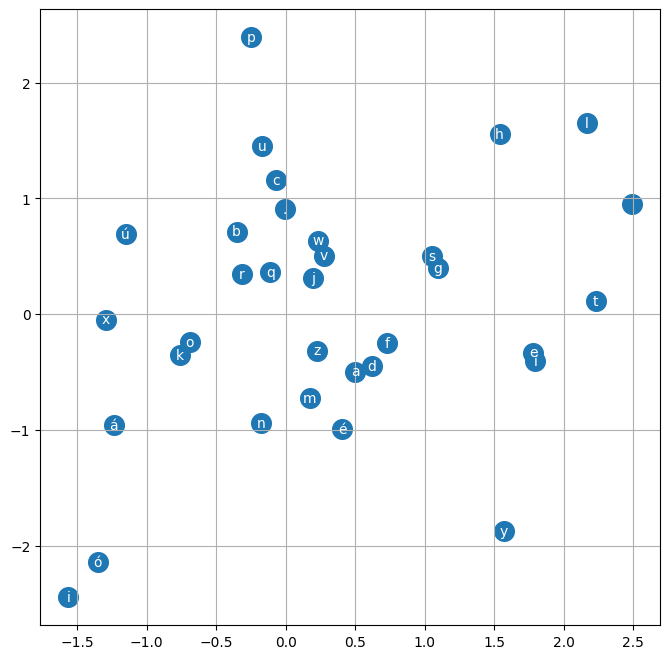

In [131]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [132]:
#Testing 
emb_tes = C[Xte] #([272, 4, 10])
h = torch.tanh(emb_tes.view(-1, block_size*dim_embedding) @ W1 + b1) # ([272, 250])
logits = h @ W2 + b2 #([272, 28])


#Cross-entropy 
loss = F.cross_entropy(logits, Yte)
print(f'Loss of our dataset:{loss.item()}')

#Perplexity 
# Reshape logits to add a dummy dimension for seq_len
logits = logits.unsqueeze(1)  # Shape will become [272, 1, 28]

# Calculate perplexity
perplexity = torch.exp(loss)
print(f"Perplexity: {perplexity.item()}")

Loss of our dataset:5.305933475494385
Perplexity: 201.52903747558594


In [133]:
# sample from the model
g = torch.Generator().manual_seed(2147048347 + 10)
generated_names_list=[]
for _ in range(200):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    generated_names= ''.join(itos[i] for i in out)
    generated_names_list.append(generated_names)
    print(generated_names)


meladys.
mbil.
jelinnifernandra.
pedro.
ednoido.
enda.
frankhermi.
debil.
maribella.
ana maragovito.
miguerita.
laura.
maribenireth.
pedro.
melifernandra.
luis.
abdemaribella.
abia.
maria de jesúsk uomatíaytátyvhoraima.
julia.
soctoritet.
vangelina.
mery.
zuleritzy.
maría andra.
debil.
bella.
oromaserlyn.
maribeetdy.
eumeli.
josé.
mela.
bella.
merytyt.
bertaxdy.
willia.
felestefanyhella.
jetzabella.
neila.
neira.
emitivo.
mira.
mery.
neila.
mamzoyca.
nica.
kena.
sixta.
maribeorgenirenais.
melady.
etjy.
joynqree.
mery.
maribelady.
luis.
mery.
maribelandra.
beatrid.
maragovito.
maribella.
jesh glady.
ana gabrietet.
josé.
merylle.
neira.
eniria de jesnaragovito.
mvis.
jetzabella.
josé jeska.
abil.
alejaneira.
josé jessimlandragovito.
neila.
mgizhlay.
debil.
ignación.
maribenifernandrey.
beatrid.
sofitet.
maría antxoynqr.
maribella.
axhy.
caxlandra.
meleana milio.
zuleidi.
maribeetdy.
jorgeniret.
josé.
neira.
yuliki.
roxymaragovito.
jocsela.
elestewuito.
jorgeniret.
maribella.
aribel.
marí

In [134]:
#Cleans unwanted characters (i.e. '.')
def output_cleaning(list_of_names):
    final= []
    for i in list_of_names:
        if i.endswith('.'): 
            name_only= i[:-1]  # deletes final '.'
            final.append(name_only)
        else:
            final.append(i)  # appends original name 
    return final

In [135]:
#Original names only 
generated_names_list= output_cleaning(generated_names_list)
original_names= [n for n in generated_names_list if n not in names]
print(f'Number of original names:{len(original_names)}')
print(original_names)

Number of original names:141
['meladys', 'mbil', 'jelinnifernandra', 'enda', 'frankhermi', 'maribella', 'ana maragovito', 'miguerita', 'maribenireth', 'melifernandra', 'abdemaribella', 'abia', 'maria de jesúsk uomatíaytátyvhoraima', 'soctoritet', 'vangelina', 'zuleritzy', 'maría andra', 'oromaserlyn', 'maribeetdy', 'eumeli', 'mela', 'merytyt', 'bertaxdy', 'willia', 'felestefanyhella', 'jetzabella', 'emitivo', 'mira', 'mamzoyca', 'nica', 'kena', 'maribeorgenirenais', 'melady', 'etjy', 'joynqree', 'maribelady', 'maribelandra', 'beatrid', 'maragovito', 'maribella', 'jesh glady', 'ana gabrietet', 'merylle', 'eniria de jesnaragovito', 'mvis', 'jetzabella', 'josé jeska', 'abil', 'alejaneira', 'josé jessimlandragovito', 'mgizhlay', 'ignación', 'maribenifernandrey', 'beatrid', 'sofitet', 'maría antxoynqr', 'maribella', 'axhy', 'caxlandra', 'meleana milio', 'zuleidi', 'maribeetdy', 'jorgeniret', 'yuliki', 'roxymaragovito', 'jocsela', 'elestewuito', 'jorgeniret', 'maribella', 'aribel', 'maría te

In [136]:
#For human-evaluation. Uncomment if you want to generate a new list.

# dict= {"names": original_names}  
# df= pd.DataFrame(dict) # opens csv with names
# df.to_csv('human_evaluation/generated_names_vzl.csv')


In [137]:
#Human-evaluation results 

review= pd.read_csv('human_evaluation/generated_names_vzl_reviewed.csv') #read csv with reviewed data
acceptable_names= [i[1] for i in review.values if i[2]==1] #takes all accepted names, labelled with 1.

print(acceptable_names)

print('Rate of acceptable names:', len(acceptable_names) / len(review))


['michel', 'briela', 'luz elentina', 'vivia', 'sherle', 'maría mery', 'michel', 'michel', 'michel', 'glentina', 'angel', 'wilmery', 'luzka', 'ziul', 'michel', 'sherle', 'angely', 'fernandra', 'angely', 'michel', 'yumaría fernandrea', 'sheriren', 'kena', 'glentina', 'michel', 'briela', 'yenifel', 'michel', 'fernandrea', 'briel', 'fernandrea', 'ziulia', 'michel', 'luzka', 'marianiela', 'michel', 'michel', 'luis daviela', 'midfet', 'sherle', 'emilifernandrea', 'maría celentina', 'michel', 'michel', 'michel', 'michel', 'angel', 'luz eleska', 'nica', 'danielentina', 'sherle', 'rohaniel', 'maria del valentina', 'verónicol', 'briel', 'wilmery', 'marianiela', 'yosmiria del valentina', 'glentina', 'michel', 'aneisforo', 'briel valenssey', 'michel', 'jhocca eduardo', 'michel', 'michel', 'maría fernandrea', 'descarla', 'briela', 'kenrique jose', 'deborelizabel', 'michel', 'michel', 'maría fernandrea', 'michel', 'elicia', 'michel', 'michel', 'briela']
Rate of acceptable names: 0.4906832298136646
